<a href="https://colab.research.google.com/github/AbhinavKumar0000/Machine_learning_practice/blob/main/Satellite_IMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install roboflow segmentation-models-pytorch albumentations -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 94.2 MB/s eta 0:00:00


# Connecting Kaggle

Downloading Dataset

In [20]:
#
# ---------------------------------------------------
# STEP 1: SETUP KAGGLE API & INSTALL LIBRARIES
# ---------------------------------------------------
#
print("Installing required libraries...")
# Install Kaggle for dataset download and p7zip to handle .7z files
!pip install kaggle pandas scikit-learn -q
!apt-get install -y p7zip-full

# Import necessary libraries
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score
from tqdm import tqdm
from google.colab import files

print("\nPlease upload your 'kaggle.json' file.")
uploaded = files.upload()

if 'kaggle.json' in uploaded:
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\n✅ Step 1 completed: Kaggle API is configured.")
else:
    print("\n❌ Error: 'kaggle.json' not found. Please upload the file and run this cell again.")

Installing required libraries...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

Please upload your 'kaggle.json' file.


Saving kaggle.json to kaggle.json

✅ Step 1 completed: Kaggle API is configured.


In [23]:
#
# -------------------------------------------
# STEP 2: DOWNLOAD AND UNZIP DATASET
# -------------------------------------------
#
# A stable, direct download link for the EuroSAT dataset
DATASET_URL = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
DATA_DIR = "/content/EuroSAT_data"

# Download the dataset using wget
print("Downloading EuroSAT dataset...")
!wget -q -O EuroSAT.zip {DATASET_URL}

# Unzip the file
print("Unzipping dataset...")
with zipfile.ZipFile("EuroSAT.zip", 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

# The images are inside a subfolder, let's define that path
SOURCE_DIR = os.path.join(DATA_DIR, "2750")

print(f"\n✅ Step 2 completed: Dataset downloaded and unzipped to {SOURCE_DIR}")

Unzipping dataset...

✅ Step 2 completed: Dataset downloaded and unzipped to /content/EuroSAT_data/2750


In [25]:
import os
import shutil
import random
import zipfile
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm

In [26]:
#
# ----------------------------------------------------------
# STEP 3: ORGANIZE DATASET INTO TRAIN/VALIDATION SPLIT
# ----------------------------------------------------------
#
print("Creating train/validation split...")
# Define paths for the new structured dataset
SPLIT_DIR = "/content/EuroSAT_split"
TRAIN_PATH = os.path.join(SPLIT_DIR, "train")
VAL_PATH = os.path.join(SPLIT_DIR, "val")

# Get list of class names from the folder names
CLASSES = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]

# Create the directories
if os.path.exists(SPLIT_DIR):
    shutil.rmtree(SPLIT_DIR)
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)

# Loop through each class folder
for class_name in CLASSES:
    # Create class folders in train and val directories
    os.makedirs(os.path.join(TRAIN_PATH, class_name), exist_ok=True)
    os.makedirs(os.path.join(VAL_PATH, class_name), exist_ok=True)

    # Get all images for the current class
    class_images = glob(os.path.join(SOURCE_DIR, class_name, "*.jpg"))
    random.shuffle(class_images)

    # Split 85% for training, 15% for validation
    split_idx = int(len(class_images) * 0.85)
    train_images = class_images[:split_idx]
    val_images = class_images[split_idx:]

    # Copy files
    for img_path in train_images:
        shutil.copy(img_path, os.path.join(TRAIN_PATH, class_name))
    for img_path in val_images:
        shutil.copy(img_path, os.path.join(VAL_PATH, class_name))

print(f"Dataset split complete. Found {len(CLASSES)} classes.")
print("Classes:", CLASSES)
print("\n✅ Step 3 completed: Dataset is organized.")


Creating train/validation split...
Dataset split complete. Found 10 classes.
Classes: ['PermanentCrop', 'HerbaceousVegetation', 'River', 'Forest', 'Residential', 'AnnualCrop', 'Industrial', 'SeaLake', 'Pasture', 'Highway']

✅ Step 3 completed: Dataset is organized.


In [27]:
#
# ----------------------------------------------------
# STEP 4: CONFIG, DATASETS, & DATALOADERS
# ----------------------------------------------------
#
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ENCODER = 'mobilenet_v2'
LEARNING_RATE = 1e-3
BATCH_SIZE = 64 # Larger batch size for faster training
NUM_EPOCHS = 15
IMAGE_SIZE = 64 # Native image size for this dataset
NUM_CLASSES = len(CLASSES)

# --- Transformations ---
# Define simple transforms: convert to tensor and normalize
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- Create Datasets using ImageFolder ---
# This is the easiest way to load data from folders
train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=transform)
val_dataset = datasets.ImageFolder(root=VAL_PATH, transform=transform)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("✅ Step 4 completed: DataLoaders are ready.")

✅ Step 4 completed: DataLoaders are ready.


In [28]:
#
# ---------------------------------------------------
# STEP 5: DEFINE MODEL, LOSS, & OPTIMIZER
# ---------------------------------------------------
#
# Load a pretrained MobileNetV2 and modify the classifier
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)
model.to(DEVICE)

# Loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler() # For faster mixed-precision training

print("✅ Step 5 completed: Model, Loss, and Optimizer are defined.")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 24.8MB/s]


✅ Step 5 completed: Model, Loss, and Optimizer are defined.


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.


In [29]:
#
# -----------------------------
# STEP 6: TRAIN THE MODEL
# -----------------------------
#
best_accuracy = 0.0
model_save_path = '/content/best_eurosat_model.pth'
print("🚀 Starting model training...")

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    model.train()
    loop = tqdm(train_loader, desc="Training")

    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss=loss.item())

    # --- Validation Phase ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"🎉 New best model saved with Accuracy: {best_accuracy:.2f}%")

print(f"\n✅ Step 6 completed: Training finished. Best model saved to {model_save_path}")

🚀 Starting model training...

--- Epoch 1/15 ---


Training:   0%|          | 0/359 [00:00<?, ?it/s]'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
User provided device_type of 'cuda', but CUDA is not available. Disabling
Training: 100%|██████████| 359/359 [08:09<00:00,  1.36s/it, loss=0.493]


Validation Accuracy: 96.32%
🎉 New best model saved with Accuracy: 96.32%

--- Epoch 2/15 ---


Training: 100%|██████████| 359/359 [06:45<00:00,  1.13s/it, loss=0.0751]


Validation Accuracy: 96.96%
🎉 New best model saved with Accuracy: 96.96%

--- Epoch 3/15 ---


Training: 100%|██████████| 359/359 [07:14<00:00,  1.21s/it, loss=0.0526]


Validation Accuracy: 96.02%

--- Epoch 4/15 ---


Training: 100%|██████████| 359/359 [07:03<00:00,  1.18s/it, loss=0.143]


Validation Accuracy: 96.77%

--- Epoch 5/15 ---


Training: 100%|██████████| 359/359 [07:18<00:00,  1.22s/it, loss=0.0564]


Validation Accuracy: 96.54%

--- Epoch 6/15 ---


Training: 100%|██████████| 359/359 [06:37<00:00,  1.11s/it, loss=0.0425]


Validation Accuracy: 95.93%

--- Epoch 7/15 ---


Training: 100%|██████████| 359/359 [06:37<00:00,  1.11s/it, loss=0.189]


Validation Accuracy: 97.16%
🎉 New best model saved with Accuracy: 97.16%

--- Epoch 8/15 ---


Training: 100%|██████████| 359/359 [06:55<00:00,  1.16s/it, loss=0.123]


Validation Accuracy: 96.20%

--- Epoch 9/15 ---


Training: 100%|██████████| 359/359 [06:52<00:00,  1.15s/it, loss=0.279]


Validation Accuracy: 97.16%

--- Epoch 10/15 ---


Training: 100%|██████████| 359/359 [06:32<00:00,  1.09s/it, loss=0.0925]


Validation Accuracy: 96.35%

--- Epoch 11/15 ---


Training: 100%|██████████| 359/359 [06:46<00:00,  1.13s/it, loss=0.0169]


Validation Accuracy: 95.95%

--- Epoch 12/15 ---


Training: 100%|██████████| 359/359 [07:20<00:00,  1.23s/it, loss=0.0278]


Validation Accuracy: 97.63%
🎉 New best model saved with Accuracy: 97.63%

--- Epoch 13/15 ---


Training: 100%|██████████| 359/359 [06:33<00:00,  1.10s/it, loss=0.115]


Validation Accuracy: 96.72%

--- Epoch 14/15 ---


Training: 100%|██████████| 359/359 [06:45<00:00,  1.13s/it, loss=0.00269]


Validation Accuracy: 97.51%

--- Epoch 15/15 ---


Training: 100%|██████████| 359/359 [07:02<00:00,  1.18s/it, loss=0.348]


Validation Accuracy: 96.86%

✅ Step 6 completed: Training finished. Best model saved to /content/best_eurosat_model.pth


'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.


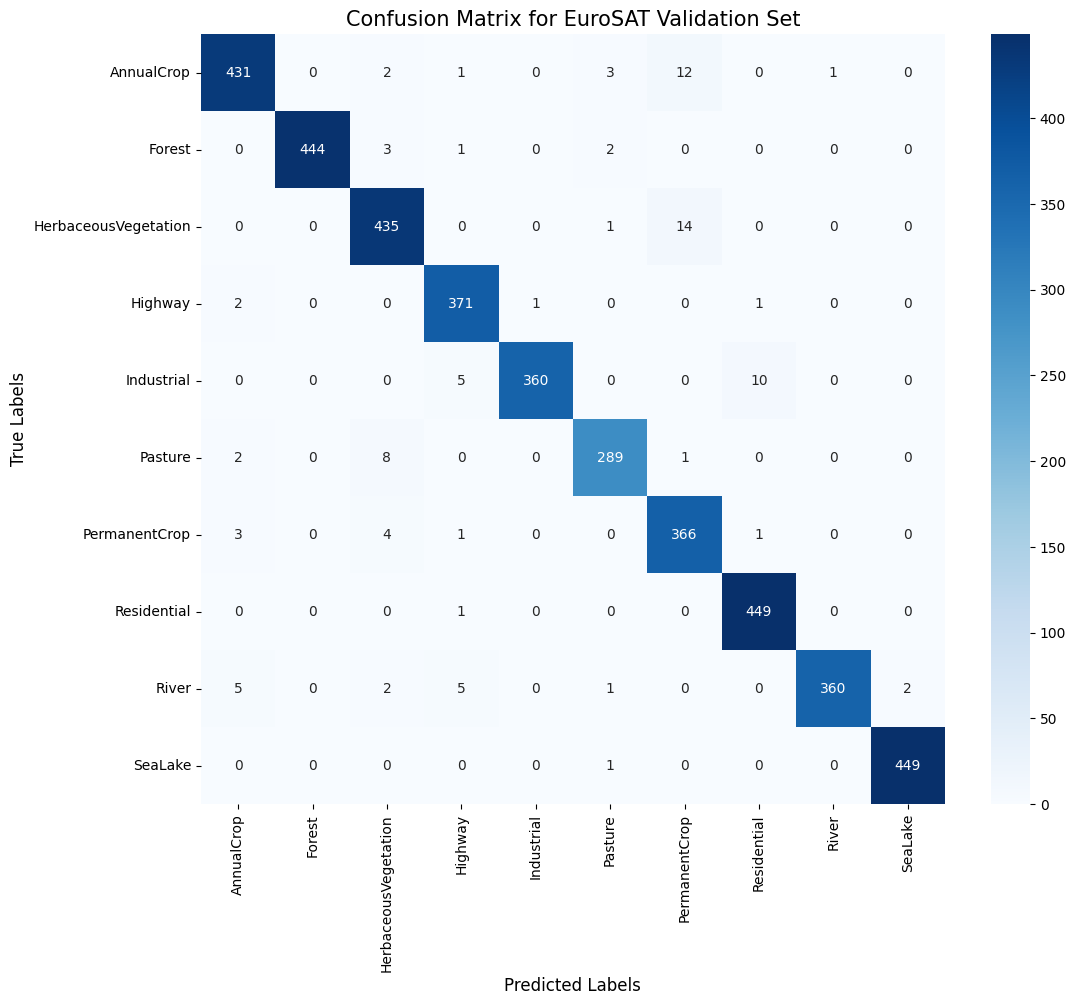

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Helper function to get all predictions ---
def get_all_preds(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels for the validation set
y_pred, y_true = get_all_preds(best_model, val_loader)
class_names = val_dataset.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for EuroSAT Validation Set', fontsize=15)
plt.show()

In [32]:
from sklearn.metrics import classification_report

# Generate and print the classification report
print("Classification Report:\n")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop       0.97      0.96      0.97       450
              Forest       1.00      0.99      0.99       450
HerbaceousVegetation       0.96      0.97      0.96       450
             Highway       0.96      0.99      0.98       375
          Industrial       1.00      0.96      0.98       375
             Pasture       0.97      0.96      0.97       300
       PermanentCrop       0.93      0.98      0.95       375
         Residential       0.97      1.00      0.99       450
               River       1.00      0.96      0.98       375
             SeaLake       1.00      1.00      1.00       450

            accuracy                           0.98      4050
           macro avg       0.98      0.98      0.98      4050
        weighted avg       0.98      0.98      0.98      4050



Found 96 misclassified images out of 4050 total validation images.


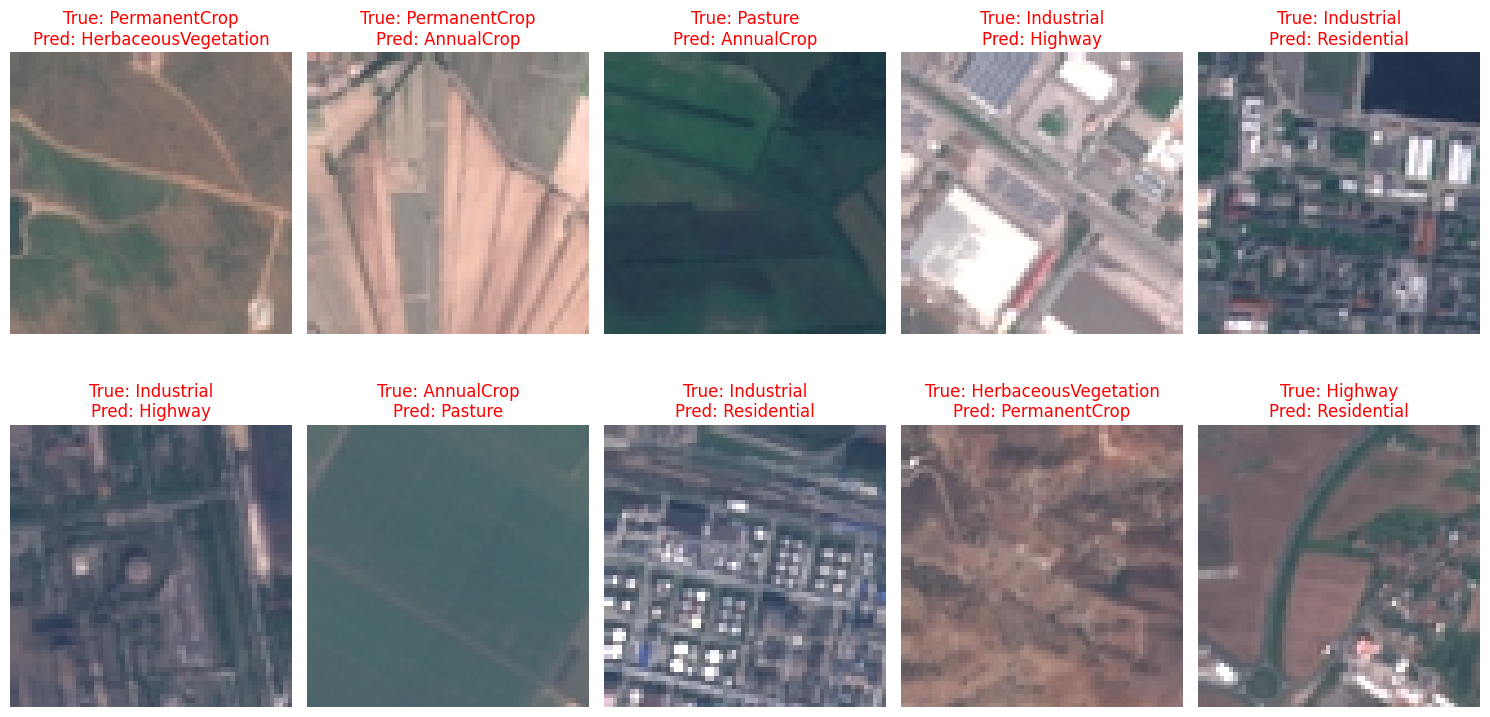

In [33]:
# Find the indices of all misclassified images
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Found {len(misclassified_indices)} misclassified images out of {len(y_true)} total validation images.")

def visualize_misclassified(dataset, misclassified_indices, preds, true_labels, num_samples=10):
    class_names = dataset.classes
    # Select random samples from the misclassified indices
    sample_indices = np.random.choice(misclassified_indices, size=min(num_samples, len(misclassified_indices)), replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(sample_indices):
        # We need the original, untransformed image for clean visualization
        img_path, _ = dataset.samples[idx]
        image_pil = Image.open(img_path).convert("RGB")

        true_label = class_names[true_labels[idx]]
        pred_label = class_names[preds[idx]]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image_pil)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color="red")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize up to 10 random misclassified images
visualize_misclassified(val_dataset, misclassified_indices, y_pred, y_true, num_samples=10)